Analyze 15/98-111 neq switching

In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings('ignore')
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole
import pandas as pd
import pickle

In [2]:
def bound_with_exp(forward_accumulated, reverse_accumulated):
    upper_dg, upper_ddg = pymbar.exp.EXP(forward_accumulated)
    lower_dg, lower_ddg = pymbar.exp.EXP(reverse_accumulated)
    return upper_dg, upper_ddg, lower_dg, lower_ddg
    
def analyze(forward_accumulated, reverse_accumulated): 
    # Compute dg, ddg
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    return dg, ddg

def analyze_bootstrap(d_works):
    d_dgs_phase = {}
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    d_dgs_phase['complex'] = (complex_dg, complex_ddg)
    d_dgs_phase['apo'] = (apo_dg, apo_ddg)
    
    binding_dg = complex_dg - apo_dg
#     binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
    return d_dgs_phase, binding_dg
    
def plot(forward_work, reverse_work, dg, ddg, dir_num, phase, output_dir, title):
#     # Substract offset
#     print("subtracting offset")
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)

    # Plot work trajectories
    print("plotting work trajs")
    for cycle in forward_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = -cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
    plt.clf()
    
    # Plot work distributions
    print("plotting work distrib")
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
    plt.clf()

    return accumulated_forward
    

## 15/98

In [5]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 98
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 98
99
about to save: complex forward
99
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/98/98_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/98/98_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/98/98_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/98/98_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 6., 10., 12., 18., 22., 12.,  9.,  3.,  2.,  5.]),
 array([ 72.60067787,  78.03079862,  83.46091937,  88.89104013,
         94.32116088,  99.75128163, 105.18140238, 110.61152313,
        116.04164389, 121.47176464, 126.90188539]),
 <BarContainer object of 10 artists>)

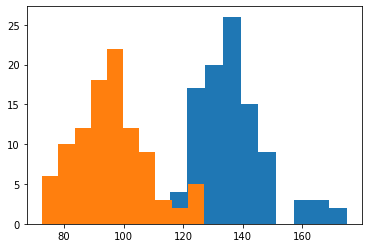

In [6]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [15]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [17]:
output_kcalmol

[5.41, (3.11, 7.34)]

In [18]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [19]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

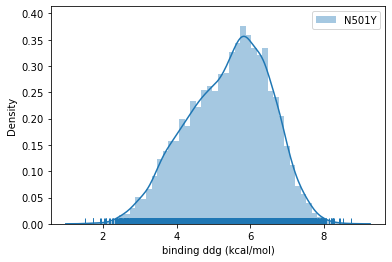

In [20]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 15/99

In [3]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 99
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 99
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/99/99_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/99/99_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/99/99_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/99/99_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 2.,  4.,  5., 14., 19., 10., 20., 15.,  8.,  3.]),
 array([ 71.82556949,  76.9430034 ,  82.06043731,  87.17787122,
         92.29530513,  97.41273904, 102.53017295, 107.64760686,
        112.76504077, 117.88247467, 122.99990858]),
 <BarContainer object of 10 artists>)

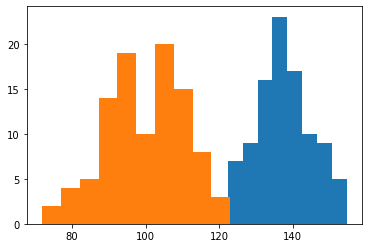

In [4]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [5]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[5.6, (3.24, 7.24)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

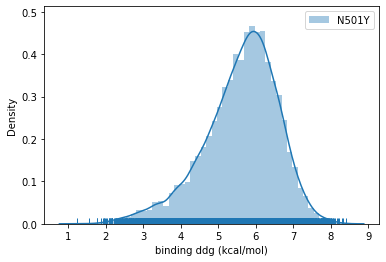

In [10]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

## 15/100

In [56]:
# Load data into dicts and plot 
titles = ["D501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 100
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print("binding DDG: ", complex_dg*KT_KCALMOL - apo_dg*KT_KCALMOL, " (", ((apo_ddg**2 + complex_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("complex DG: ", complex_dg*KT_KCALMOL, " (", complex_ddg*KT_KCALMOL,")")
    print("apo DG: ", apo_dg*KT_KCALMOL, " (", apo_ddg*KT_KCALMOL,")")
    
    complex_upper_dg, complex_upper_ddg, complex_lower_dg, complex_lower_ddg = bound_with_exp(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_upper_dg, apo_upper_ddg, apo_lower_dg, apo_lower_ddg = bound_with_exp(d_works['apo']['forward'], d_works['apo']['reverse'])
    print("binding DDG (upper): ", complex_upper_dg*KT_KCALMOL - apo_upper_dg*KT_KCALMOL, " (", ((apo_upper_ddg**2 + complex_upper_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("complex DG: ", complex_upper_dg*KT_KCALMOL, " (", complex_upper_ddg*KT_KCALMOL,")")
    print("apo DG: ", apo_upper_dg*KT_KCALMOL, " (", apo_upper_ddg*KT_KCALMOL,")")
    print("binding DDG (lower): ", complex_lower_dg*-KT_KCALMOL - apo_lower_dg*-KT_KCALMOL, " (", ((apo_lower_ddg**2 + complex_lower_ddg**2)**0.5)*-KT_KCALMOL, ")")
    print("complex DG: ", complex_lower_dg*-KT_KCALMOL, " (", complex_lower_ddg*-KT_KCALMOL,")")
    print("apo DG: ", apo_lower_dg*-KT_KCALMOL, " (", apo_lower_ddg*-KT_KCALMOL,")")
    

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 100
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/100/100_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/100/100_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/100/100_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/100/100_apo_work_dist.png
binding DDG:  -8.17760476170172  ( 0.8618360665630025 )
complex DG:  -24.41993650052538  ( 0.8278334518639207 )
apo DG:  -16.242331738823662  ( 0.23969393318115884 )
binding DDG (upper):  -7.1789876011262415  ( 0.7100229661974187 )
complex DG:  -24.10968019251559  ( 0.5931157612869774 )
apo DG:  -16.93069259138935  ( 0.39031564949505926 )
binding DDG (lower):  -8.49015227642364  ( -0.6489093033472743 )
complex DG:  -25.118473451875843  ( -

<Figure size 432x288 with 0 Axes>

In [46]:
# Bound with EXP


In [48]:
complex_upper_dg, complex_upper_ddg, 

(-40.44154006427378, 0.9948914556853273)

(array([ 4.,  8., 13., 18., 21., 18.,  9.,  7.,  1.,  1.]),
 array([-90.16971121, -84.90565902, -79.64160683, -74.37755464,
        -69.11350245, -63.84945026, -58.58539806, -53.32134587,
        -48.05729368, -42.79324149, -37.5291893 ]),
 <BarContainer object of 10 artists>)

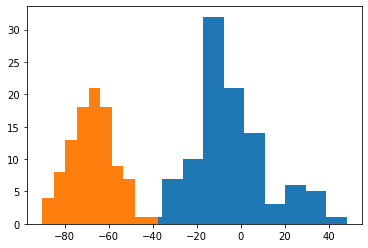

In [34]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [35]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [36]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [37]:
output_kcalmol

[-8.09, (-11.95, -4.32)]

In [38]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [39]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [4]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

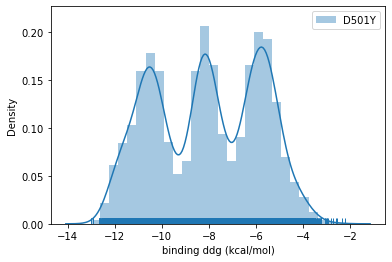

In [5]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [7]:
np.std(np.array(ddgs[forward])*KT_KCALMOL)

2.2677928138143346

In [43]:
dgs_phase[100]

[{'complex': (-37.52684049681961, 1.2154348772128662),
  'apo': (-26.899197178783712, 0.3755128334865373)},
 {'complex': (-43.50363830933394, 1.1071157870224537),
  'apo': (-26.70241194844585, 0.389889230451633)},
 {'complex': (-41.3523096152761, 1.404398805069801),
  'apo': (-27.091825102116047, 0.37774387194334)},
 {'complex': (-44.27081855480174, 1.0388339660637054),
  'apo': (-26.66702800126189, 0.3755797554485731)},
 {'complex': (-39.782883498009056, 0.7575957918884707),
  'apo': (-26.91499597408786, 0.3459627910647482)},
 {'complex': (-41.3459354542892, 1.4042231085515704),
  'apo': (-28.197893733824127, 0.4754988111191073)},
 {'complex': (-44.53996247966944, 0.8358919633421933),
  'apo': (-28.46235302282063, 0.4939550279581089)},
 {'complex': (-38.37498336799121, 1.0705532706479168),
  'apo': (-26.27507031635537, 0.3804255368956422)},
 {'complex': (-36.82804884225548, 1.2269398880624636),
  'apo': (-27.083243454318904, 0.39979689383868683)},
 {'complex': (-36.58777423346527, 1.3

In [44]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [45]:
output_kcalmol_apo

[-16.27, (-17.1, -15.58)]

In [46]:
output_kcalmol_complex

[-24.36, (-28.07, -20.66)]

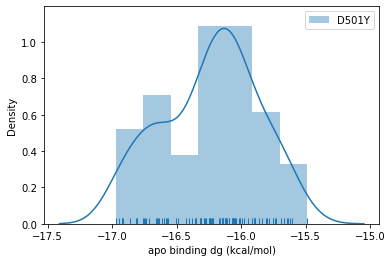

In [47]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

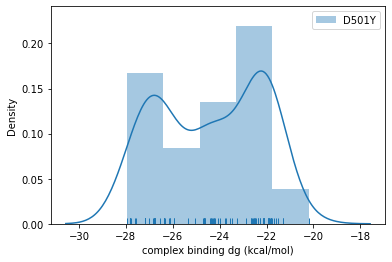

In [48]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/101

In [3]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 101
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print("binding DDG: ", complex_dg*KT_KCALMOL - apo_dg*KT_KCALMOL, " (", ((apo_ddg**2 + complex_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_dg*KT_KCALMOL, " (", complex_ddg*KT_KCALMOL,")")
    print("\tapo DG: ", apo_dg*KT_KCALMOL, " (", apo_ddg*KT_KCALMOL,")")
    
    complex_upper_dg, complex_upper_ddg, complex_lower_dg, complex_lower_ddg = bound_with_exp(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_upper_dg, apo_upper_ddg, apo_lower_dg, apo_lower_ddg = bound_with_exp(d_works['apo']['forward'], d_works['apo']['reverse'])
    print("binding DDG (upper): ", complex_upper_dg*KT_KCALMOL - apo_upper_dg*KT_KCALMOL, " (", ((apo_upper_ddg**2 + complex_upper_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_upper_dg*KT_KCALMOL, " (", complex_upper_ddg*KT_KCALMOL,")")
    print("\tapo DG: ", apo_upper_dg*KT_KCALMOL, " (", apo_upper_ddg*KT_KCALMOL,")")
    print("binding DDG (lower): ", complex_lower_dg*-KT_KCALMOL - apo_lower_dg*-KT_KCALMOL, " (", ((apo_lower_ddg**2 + complex_lower_ddg**2)**0.5)*-KT_KCALMOL, ")")
    print("\tcomplex DG: ", complex_lower_dg*-KT_KCALMOL, " (", complex_lower_ddg*-KT_KCALMOL,")")
    print("\tapo DG: ", apo_lower_dg*-KT_KCALMOL, " (", apo_lower_ddg*-KT_KCALMOL,")")
     

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 101
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/101/101_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/101/101_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/101/101_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/101/101_apo_work_dist.png
binding DDG:  6.393769432622705  ( 0.37894431084663893 )
	complex DG:  72.47565055964398  ( 0.2487178894473215 )
	apo DG:  66.08188112702128  ( 0.28589893702478864 )
binding DDG (upper):  3.56434261373974  ( 0.49261330934311637 )
	complex DG:  70.80330403381843  ( 0.40163341177116224 )
	apo DG:  67.2389614200787  ( 0.28523407070515416 )
binding DDG (lower):  5.171662962410622  ( -0.6550216848076331 )
	complex DG:  72.79043518276687  ( -0.2

<Figure size 432x288 with 0 Axes>

(array([ 2.,  0.,  1.,  4., 15., 23., 15., 12., 14., 14.]),
 array([ 60.32283194,  66.86225004,  73.40166813,  79.94108623,
         86.48050433,  93.01992242,  99.55934052, 106.09875862,
        112.63817671, 119.17759481, 125.71701291]),
 <BarContainer object of 10 artists>)

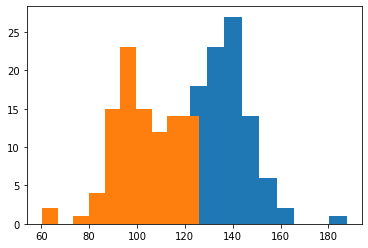

In [4]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [5]:
np.min(d_works['complex']['forward'])

114.68461284877577

In [10]:
for i, val in enumerate(d_works['complex']['forward']):
    if val < 124:
        print(i, val)

16 119.97206974964992
35 122.11408575356683
36 121.15509761907886
49 121.3035222944735
50 116.86455490357022
61 121.08291465787849
77 120.94683120090193
82 115.26823931386434
92 123.23198645637977
96 114.68461284877577
98 119.8048862075043


In [5]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[6.38, (5.13, 7.62)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

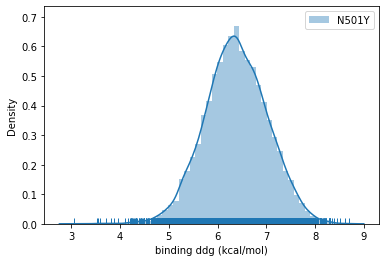

In [10]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [11]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.6420463719906756

In [28]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [29]:
output_kcalmol_apo

[66.1, (65.51, 66.8)]

In [30]:
output_kcalmol_complex

[72.48, (71.42, 73.57)]

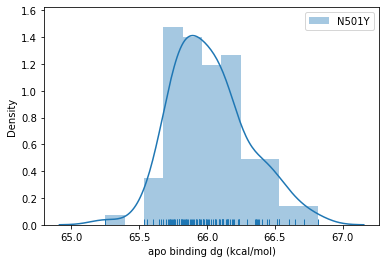

In [31]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

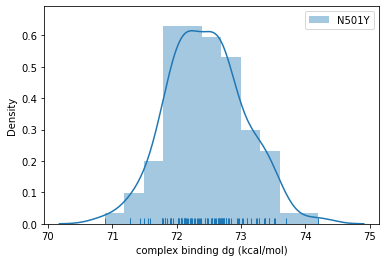

In [32]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/102

In [12]:
# Load data into dicts and plot 
titles = ["D501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 102
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 102
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/102/102_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/102/102_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/102/102_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/102/102_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 7.,  2.,  7., 12., 17., 25., 12., 10.,  4.,  4.]),
 array([-92.09512707, -86.66601337, -81.23689968, -75.80778599,
        -70.37867229, -64.9495586 , -59.52044491, -54.09133122,
        -48.66221752, -43.23310383, -37.80399014]),
 <BarContainer object of 10 artists>)

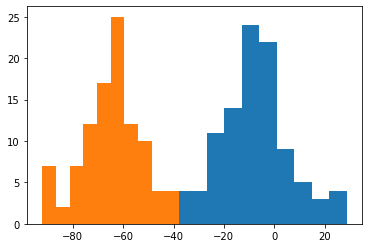

In [4]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [5]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[-6.42, (-7.93, -4.51)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [13]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

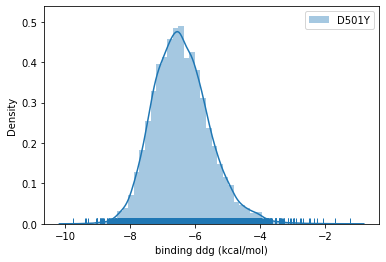

In [11]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [15]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.8682643578873515

In [13]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [14]:
output_kcalmol_apo

[-17.03, (-17.69, -16.31)]

In [15]:
output_kcalmol_complex

[-23.45, (-24.78, -21.56)]

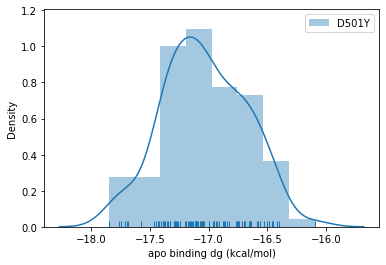

In [16]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

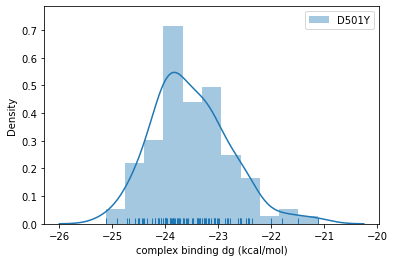

In [17]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/103

In [16]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 103
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 103
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/103/103_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/103/103_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/103/103_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/103/103_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 7.,  6., 14., 11., 11., 12., 11.,  9., 11.,  8.]),
 array([ 79.83417969,  84.28255994,  88.73094019,  93.17932044,
         97.6277007 , 102.07608095, 106.5244612 , 110.97284145,
        115.4212217 , 119.86960195, 124.3179822 ]),
 <BarContainer object of 10 artists>)

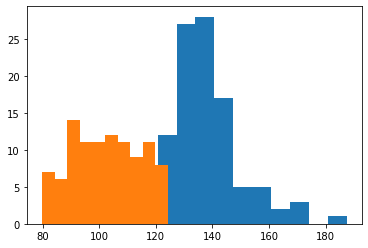

In [19]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [20]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [22]:
output_kcalmol

[6.74, (5.85, 7.66)]

In [23]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [24]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [17]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

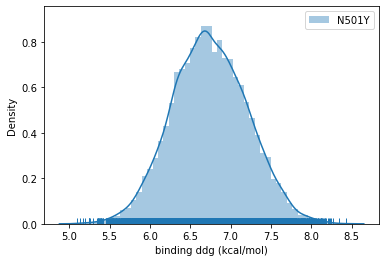

In [26]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [18]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.46718413071325304

In [28]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [29]:
output_kcalmol_apo

[66.29, (65.83, 66.71)]

In [30]:
output_kcalmol_complex

[73.03, (72.25, 73.84)]

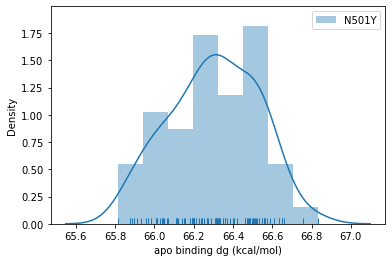

In [31]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

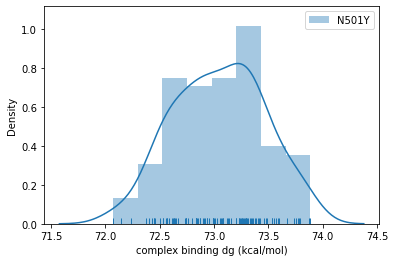

In [32]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/104

In [19]:
# Load data into dicts and plot 
titles = ["D501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 104
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 104
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/104/104_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/104/104_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/104/104_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/104/104_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 1.,  0.,  6.,  9., 12., 27., 18., 16.,  6.,  5.]),
 array([-108.69680701, -101.51370704,  -94.33060707,  -87.14750709,
         -79.96440712,  -72.78130715,  -65.59820718,  -58.4151072 ,
         -51.23200723,  -44.04890726,  -36.86580729]),
 <BarContainer object of 10 artists>)

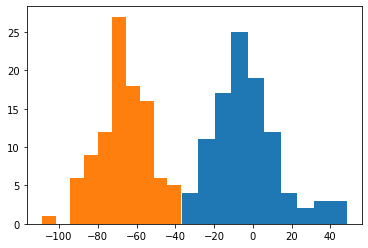

In [4]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [5]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[-4.73, (-6.47, -2.53)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [21]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

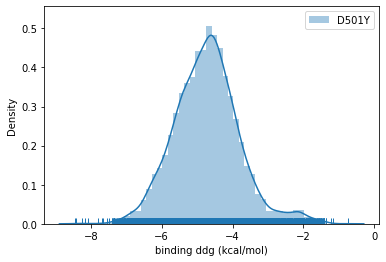

In [11]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [22]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.9325669731491429

In [13]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [14]:
output_kcalmol_apo

[-17.24, (-17.84, -16.6)]

In [15]:
output_kcalmol_complex

[-21.96, (-23.61, -19.73)]

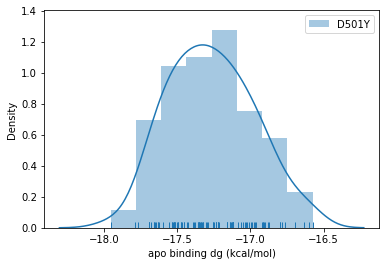

In [16]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

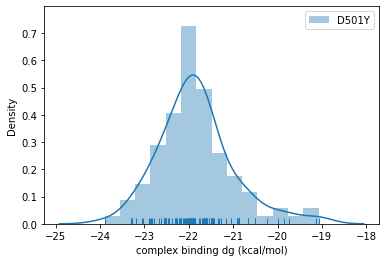

In [17]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/105

In [23]:
# Load data into dicts and plot 
titles = ["D501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 105
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 105
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/105/105_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/105/105_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/105/105_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/105/105_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 1.,  2.,  6.,  6., 11., 27., 22., 14.,  6.,  5.]),
 array([-96.08729584, -90.43472707, -84.78215829, -79.12958951,
        -73.47702074, -67.82445196, -62.17188319, -56.51931441,
        -50.86674563, -45.21417686, -39.56160808]),
 <BarContainer object of 10 artists>)

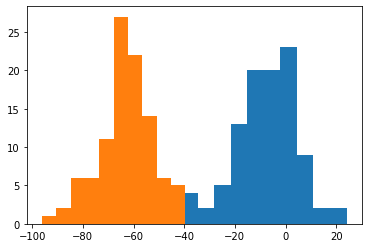

In [4]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [5]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[-7.56, (-8.94, -5.95)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [24]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

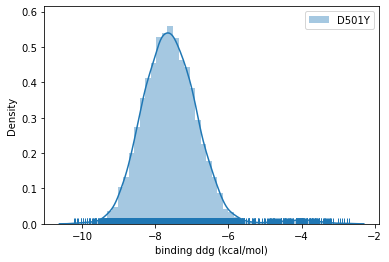

In [11]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [25]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.825114919054056

In [13]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [14]:
output_kcalmol_apo

[-16.73, (-17.38, -16.05)]

In [15]:
output_kcalmol_complex

[-24.29, (-25.5, -22.86)]

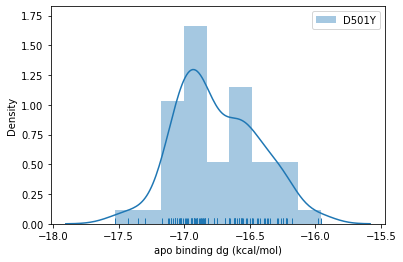

In [16]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

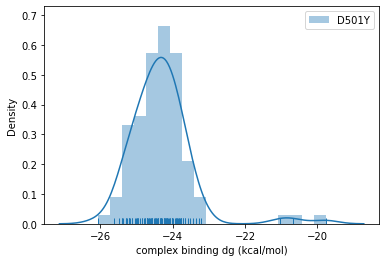

In [17]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/106

In [18]:
# Load data into dicts and plot 
titles = ["D501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 106
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 106
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/106/106_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/106/106_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/106/106_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/106/106_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 2.,  1., 10.,  6., 16., 17., 17., 17.,  9.,  5.]),
 array([-89.27103931, -84.09939693, -78.92775454, -73.75611216,
        -68.58446978, -63.4128274 , -58.24118501, -53.06954263,
        -47.89790025, -42.72625787, -37.55461548]),
 <BarContainer object of 10 artists>)

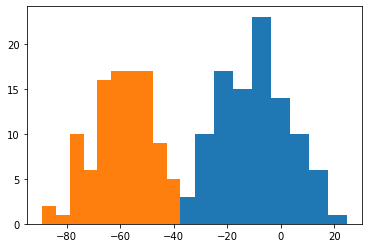

In [19]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [20]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [22]:
output_kcalmol

[-6.14, (-8.81, -4.06)]

In [23]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [24]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [25]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

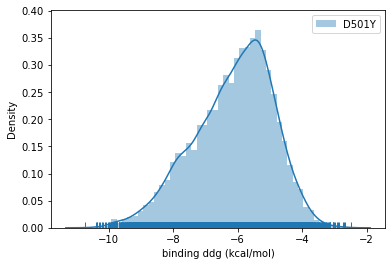

In [26]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [27]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL) / np.sqrt(10000)

0.012344191387849202

In [28]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [29]:
output_kcalmol_apo

[-16.87, (-17.44, -16.27)]

In [30]:
output_kcalmol_complex

[-23.01, (-25.62, -21.03)]

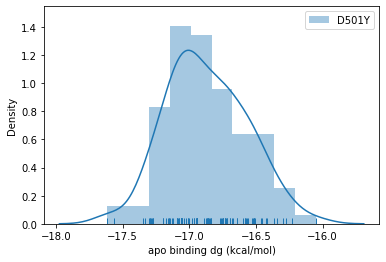

In [31]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

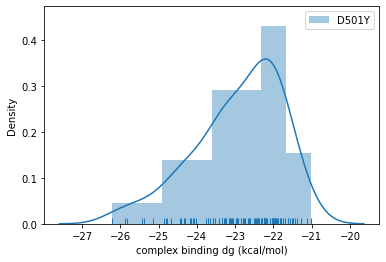

In [32]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/107

In [3]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 107
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 107
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/107/107_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/107/107_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/107/107_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/107/107_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 5.,  3.,  9., 19., 18., 19., 10.,  4.,  7.,  6.]),
 array([ 74.25177233,  79.60066334,  84.94955436,  90.29844537,
         95.64733639, 100.9962274 , 106.34511841, 111.69400943,
        117.04290044, 122.39179145, 127.74068247]),
 <BarContainer object of 10 artists>)

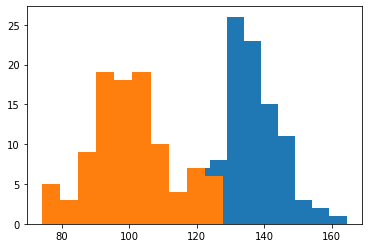

In [4]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [5]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[5.97, (4.45, 7.27)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [10]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

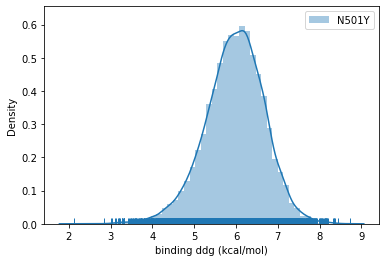

In [11]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [12]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL) / np.sqrt(10000)

0.007092508285801375

In [13]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [14]:
output_kcalmol_apo

[66.57, (66.11, 67.05)]

In [15]:
output_kcalmol_complex

[72.54, (71.07, 73.75)]

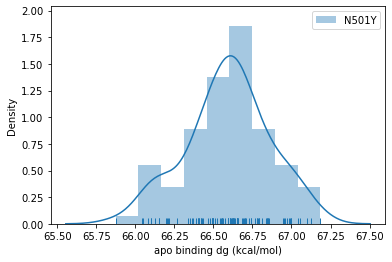

In [16]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

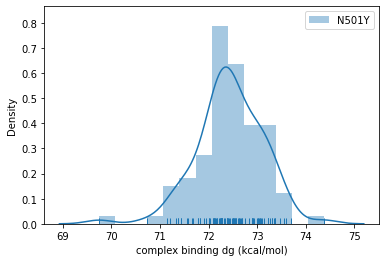

In [17]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/108

In [33]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 108
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 108
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/108/108_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/108/108_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/108/108_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/108/108_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 2.,  3.,  6., 11., 14., 15., 18., 15.,  9.,  7.]),
 array([ 73.13211012,  78.21295982,  83.29380951,  88.3746592 ,
         93.45550889,  98.53635858, 103.61720827, 108.69805796,
        113.77890766, 118.85975735, 123.94060704]),
 <BarContainer object of 10 artists>)

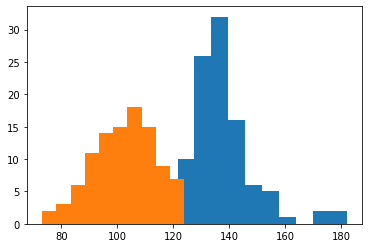

In [34]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [35]:
np.std(d_works['complex']['forward'])

11.047282237443461

In [36]:
np.std(d_works['complex']['reverse']*-1)

10.997621563777273

In [5]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[6.91, (5.78, 7.87)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [8]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

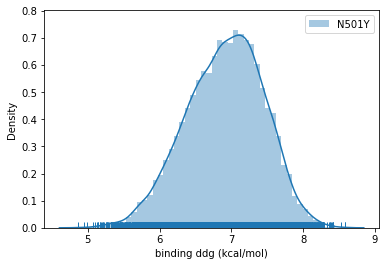

In [10]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [17]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.5399799741849337

In [12]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [13]:
output_kcalmol_apo

[66.31, (65.93, 66.66)]

In [14]:
output_kcalmol_complex

[73.22, (72.17, 74.09)]

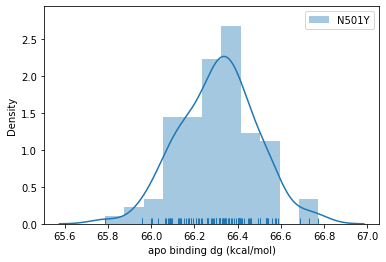

In [15]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

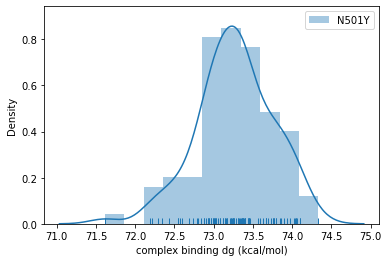

In [16]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/109

In [37]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 109
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 109
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/109/109_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/109/109_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/109/109_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/109/109_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([ 9., 10., 18., 15., 16.,  8.,  8., 10.,  4.,  2.]),
 array([ 79.16606315,  83.81863053,  88.47119791,  93.12376529,
         97.77633267, 102.42890005, 107.08146743, 111.73403482,
        116.3866022 , 121.03916958, 125.69173696]),
 <BarContainer object of 10 artists>)

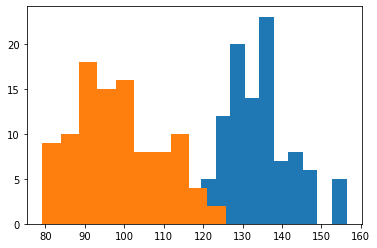

In [38]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [39]:
np.std(d_works['complex']['forward'])

8.127364208591532

In [40]:
np.std(d_works['complex']['reverse']*-1)

11.034107691855507

In [20]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [22]:
output_kcalmol

[6.05, (4.88, 7.23)]

In [23]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [24]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [25]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

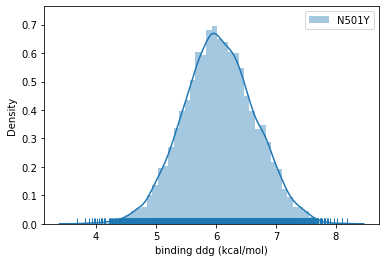

In [26]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [27]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL) / np.sqrt(10000)

0.0060247277831465725

In [28]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [29]:
output_kcalmol_apo

[66.21, (65.84, 66.64)]

In [30]:
output_kcalmol_complex

[72.26, (71.17, 73.38)]

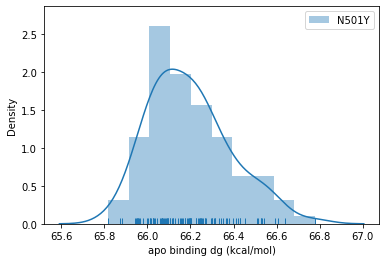

In [31]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

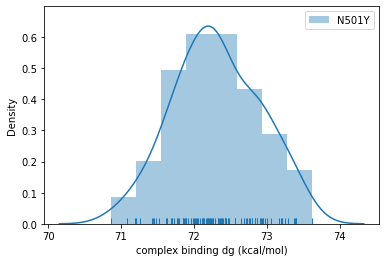

In [32]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/110

In [41]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 110
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(500):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 110
500
about to save: complex forward
500
about to save: complex reverse
500
about to save: apo forward
500
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/110/110_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/110/110_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/110/110_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/110/110_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

(array([  4.,   4.,  41.,  72.,  94.,  96., 100.,  58.,  25.,   6.]),
 array([ 67.62905571,  73.88154384,  80.13403198,  86.38652011,
         92.63900825,  98.89149638, 105.14398452, 111.39647266,
        117.64896079, 123.90144893, 130.15393706]),
 <BarContainer object of 10 artists>)

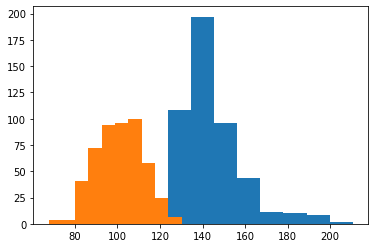

In [42]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

In [43]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[5.97, (4.45, 7.27)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [10]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

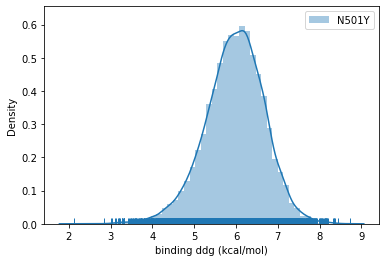

In [11]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [12]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL) / np.sqrt(10000)

0.007092508285801375

In [13]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [14]:
output_kcalmol_apo

[66.57, (66.11, 67.05)]

In [15]:
output_kcalmol_complex

[72.54, (71.07, 73.75)]

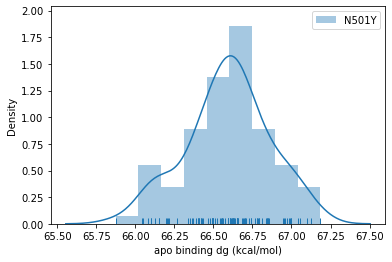

In [16]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

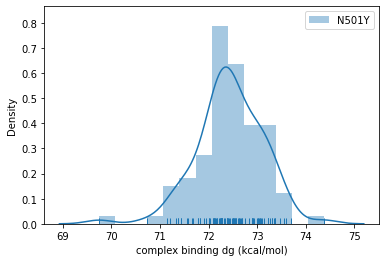

In [17]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()

## 15/111

In [3]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 111
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(500):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
        

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 111
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/111/111_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/111/111_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/111/111_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/111/111_apo_work_dist.png


<Figure size 432x288 with 0 Axes>

In [15]:
d_works['apo']['forward']

array([159538.34956467, 162558.99018735, 115962.58093846, 192613.82354545,
       153634.75990577, 222927.76822346, 147457.81042827, 166829.5403137 ,
       108151.53342929, 162270.61063362, 107332.05237182, 123303.56231555,
        88065.30262187, 123689.1293128 , 200381.48259827, 197836.4602025 ,
        97842.79960781, 123020.50229442, 229227.79610928, 135345.87049295,
       217267.58176321, 145152.78298413, 113195.3811762 , 130065.3825477 ,
       137048.23012138, 106254.44468309, 190174.98538578, 185608.55313458,
       159276.91046295, 193221.54614683, 122623.75092401, 151232.39423222,
       205160.60113928,  71374.79690719, 166854.2540671 ,  87943.95806361,
       137172.82649035, 145538.91876794, 216912.65950855, 133527.92152557,
       204122.64524631, 128961.49033171, 206235.92323033, 108313.56846499,
       165974.43988471, 151039.7234614 , 167276.17473259, 209258.12952944,
        95490.08879993, 111601.02392849,  95687.44409908, 101080.38882286,
       141595.53871779, 1

(array([ 3., 10., 11., 16., 14., 16.,  7., 12.,  6.,  5.]),
 array([ 71374.79690719,  87228.35713631, 103081.91736542, 118935.47759454,
        134789.03782366, 150642.59805278, 166496.1582819 , 182349.71851101,
        198203.27874013, 214056.83896925, 229910.39919837]),
 <BarContainer object of 10 artists>)

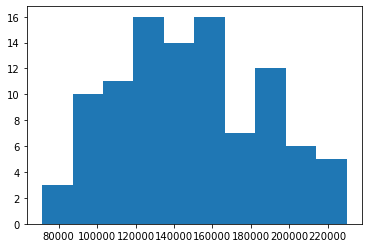

In [16]:
plt.hist(d_works['complex']['forward'])
# plt.hist(d_works['complex']['reverse']*-1)

In [43]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [7]:
output_kcalmol

[5.97, (4.45, 7.27)]

In [8]:
# pd.DataFrame([output_kcalmol]).to_csv(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/analysis_{titles[0]}_{titles[1]}.csv")

In [9]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [10]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

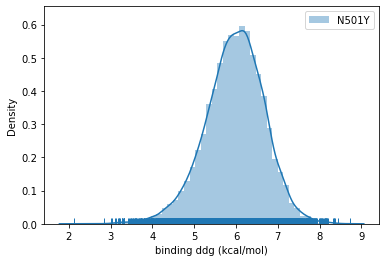

In [11]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [12]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL) / np.sqrt(10000)

0.007092508285801375

In [13]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [14]:
output_kcalmol_apo

[66.57, (66.11, 67.05)]

In [15]:
output_kcalmol_complex

[72.54, (71.07, 73.75)]

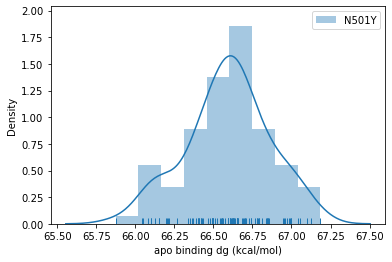

In [16]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

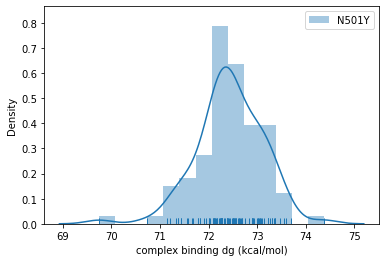

In [17]:
# Plot ddgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()